# Differentially private random feature models: real data

We test our proposed model on two real datasets and compare different privacy budget $\epsilon_p$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time

from scipy import io
from matplotlib import cm

from DP_RF import *

## Data processing

In [26]:
################ Preprocessing

def one_hot(df, cols): # idk if sklearns one-hot encoder is similar
    """
    df: pandas DataFrame
    param: cols a list of columns to encode 
    return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

def numeric_scaler(df, cols):
    '''
    df: pandas dataframe
    numeric_cols: (array of strings) column names for numeric variables

    no return: does inplace operation
    '''
    df_new = df.copy()
    mmscaler = MinMaxScaler()
    df_new[cols] = mmscaler.fit_transform(df_new[cols])
    return df_new

def numeric_scaler_numpy(arr):
    '''
    arr (numpy array):  
    '''
    mmscaler = MinMaxScaler()
    scaled_arr = mmscaler.fit_transform(arr)
    return scaled_arr
    

In [27]:
# Preprocessing
df_medical = pd.read_csv('insurance.csv')
numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']

df_medical_mm = numeric_scaler(df_medical, numeric_all) # minmax scaling for all numeric columns, so all elements in [0,1]
df_medical_mm_oh = one_hot(df_medical_mm, cat_all)
df_medical_mm_oh.drop(cat_all, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_medical_mm_oh = df_medical_mm_oh * 1.0 # make bool true, false into 1.0, 0.0

X = df_medical_mm_oh.drop('charges', axis=1)
X = X.to_numpy() # now (n, d+1) dimensional, linear regression in d+1 is affine in d
y = df_medical_mm_oh['charges'].to_numpy()

In [28]:
################################# Compare different epsilon's
# number of random features
N_range = range(2000,12000,2000)
gamma = 20

# privacy budget
epsilon = [0.01,0.1,1]
# privacy parameter
delta = 1e-5

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.1)
# numner of iterations, also number of training samples
T = np.size(y_train)

# error and time
K = 10   # repeat K times
err_np = np.zeros( (len(N_range), K) )
err_eps1 = np.zeros( (len(N_range), K) )
err_eps2 = np.zeros( (len(N_range), K) )
err_eps3 = np.zeros( (len(N_range), K) )

In [29]:
for i in range(len(N_range)):
    
    N = N_range[i]
    Delta_c = 4/np.sqrt(N)    # l2-sensitivity
    
    for j in range(K):
    
        # random feature matrix
        A_train, A_test = RF_Gaussian(gamma, N, x_train, x_test)
    
        c = randomized_kaczmarz(A_train, y_train, np.zeros((N,)), T)   # non-private
        err_np[i,j] = np.linalg.norm(y_test - A_test @ c)**2 / np.size(y_test)
        
        # epsilon = 0.25
        c_eps1 = private(c, Delta_c, 0.25, delta, "Gaussian")  # private ours
        err_eps1[i,j] = np.linalg.norm(y_test - A_test @ c_eps1)**2 / np.size(y_test)
        
        # epsilon = 0.5
        c_eps2 = private(c, Delta_c, 0.5, delta, "Gaussian")  # private ours
        err_eps2[i,j] = np.linalg.norm(y_test - A_test @ c_eps2)**2 / np.size(y_test)
    
        # epsilon = 1
        c_eps3 = private(c, Delta_c, 1, delta, "Gaussian")  # private ours
        err_eps3[i,j] = np.linalg.norm(y_test - A_test @ c_eps3)**2 / np.size(y_test)

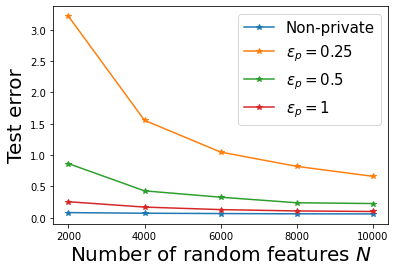

In [30]:
plt.plot(N_range, np.mean(err_np, axis=1), '-*', label='Non-private')
plt.plot(N_range, np.mean(err_eps1, axis=1), '-*', label=r'$\epsilon_p = 0.25$')
plt.plot(N_range, np.mean(err_eps2, axis=1), '-*', label=r'$\epsilon_p = 0.5$')
plt.plot(N_range, np.mean(err_eps3, axis=1), '-*', label=r'$\epsilon_p = 1$')
plt.legend(fontsize=15)
plt.xticks(N_range)
plt.ylabel('Test error', size=20)
plt.xlabel(r'Number of random features $N$', size=20)
plt.savefig('real1_eps.pdf', bbox_inches = 'tight')

## real data: wine quality

In [17]:
# read data and data processing
wine = pd.read_csv('winequality-red.csv', sep=';')
wine_new = wine.to_numpy()

X = wine_new[:,:11]
y = wine_new[:,-1]

mmscaler = MinMaxScaler()
X = mmscaler.fit_transform(X)

In [21]:
# read data and data processing
wine = pd.read_csv('winequality-red.csv', sep=';')
wine_new = wine.to_numpy()

mmscaler = MinMaxScaler()
wine_new = mmscaler.fit_transform(wine_new)

X = wine_new[:,:11]
y = wine_new[:,-1]

In [22]:
################################ Compare different epsilon's
# number of random features
N_range = range(2000,12000,2000)
gamma = 20

# privacy budget
delta = 1e-5

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.1)
# numner of iterations, also number of training samples
T = np.size(y_train)

# error and time
K = 10   # repeat K times
err_np = np.zeros( (len(N_range), K) )
err_eps1 = np.zeros( (len(N_range), K) )
err_eps2 = np.zeros( (len(N_range), K) )
err_eps3 = np.zeros( (len(N_range), K) )

In [23]:
for i in range(len(N_range)):
    
    N = N_range[i]
    Delta_c = 4/np.sqrt(N)    # l2-sensitivity
    
    for j in range(K):
    
        # random feature matrix
        A_train, A_test = RF_Gaussian(gamma, N, x_train, x_test)
    
        c = randomized_kaczmarz(A_train, y_train, np.zeros((N,)), T)   # non-private
        err_np[i,j] = np.linalg.norm(y_test - A_test @ c)**2 / np.size(y_test)
        
        # epsilon = 0.25
        c_eps1 = private(c, Delta_c, 0.25, delta, "Gaussian")  # private ours
        err_eps1[i,j] = np.linalg.norm(y_test - A_test @ c_eps1)**2 / np.size(y_test)
        
        # epsilon = 0.5
        c_eps2 = private(c, Delta_c, 0.5, delta, "Gaussian")  # private ours
        err_eps2[i,j] = np.linalg.norm(y_test - A_test @ c_eps2)**2 / np.size(y_test)
    
        # epsilon = 1
        c_eps3 = private(c, Delta_c, 1, delta, "Gaussian")  # private ours
        err_eps3[i,j] = np.linalg.norm(y_test - A_test @ c_eps3)**2 / np.size(y_test)

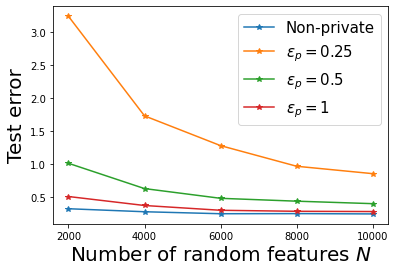

In [24]:
plt.plot(N_range, np.mean(err_np, axis=1), '-*', label='Non-private')
plt.plot(N_range, np.mean(err_eps1, axis=1), '-*', label=r'$\epsilon_p = 0.25$')
plt.plot(N_range, np.mean(err_eps2, axis=1), '-*', label=r'$\epsilon_p = 0.5$')
plt.plot(N_range, np.mean(err_eps3, axis=1), '-*', label=r'$\epsilon_p = 1$')
plt.legend(fontsize=15)
plt.xticks(N_range)
plt.ylabel('Test error', size=20)
plt.xlabel(r'Number of random features $N$', size=20)
plt.savefig('real2_eps.pdf', bbox_inches = 'tight')